In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import title
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

Импортируем данные из файла

In [44]:
df = pd.read_csv('data/HR.csv')

df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


Посчитаем количество пропусков

In [45]:
print(df.isnull().sum())

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64


Пропусков нет

In [46]:
print(df.dtypes)

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
work_accident              int64
left                       int64
promotion_last_5years      int64
department                object
salary                    object
dtype: object


Все признаки числовые кроме *salary* и *department*

Найдем количество людей, покинувших компанию

In [47]:
print(df['left'].value_counts())

left
0    11428
1     3571
Name: count, dtype: int64


In [48]:
df.drop(['salary', 'department'], axis=1).groupby('left').mean()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,promotion_last_5years
left,,,,,,,
0,0.666810,0.715473,3.786664,199.060203,3.380032,0.175009,0.026251
1,0.440098,0.718113,3.855503,207.419210,3.876505,0.047326,0.005321


Видим, что уровень удовлетворенности у ушедших ниже, чем у оставшихся (логично 🧐).
`last_evaluation` одинаков для обеих категорий и вряд ли на что-то влияет, его можно отбросить

In [49]:
df.drop('last_evaluation', axis=1, inplace=True)

Рассмотрим текучесть кадров по признакам

In [50]:
def plot_feature_vs_left(df, feature):
    pd.crosstab(df[feature], df['left']).plot(kind='bar')
    plt.title(f'Число ушедших из компании по признаку {feature}')
    plt.xlabel(feature)
    plt.ylabel('Люди, шт')
    plt.show()

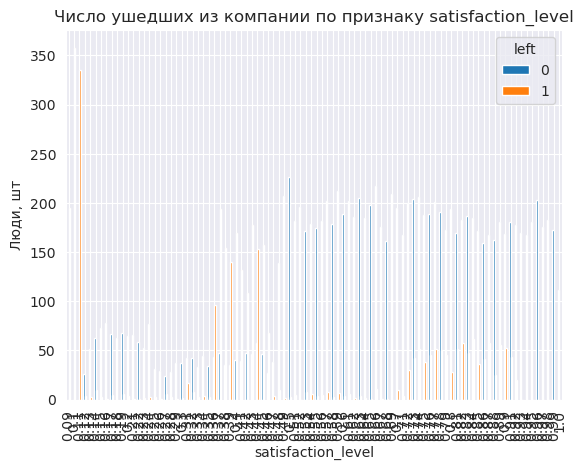

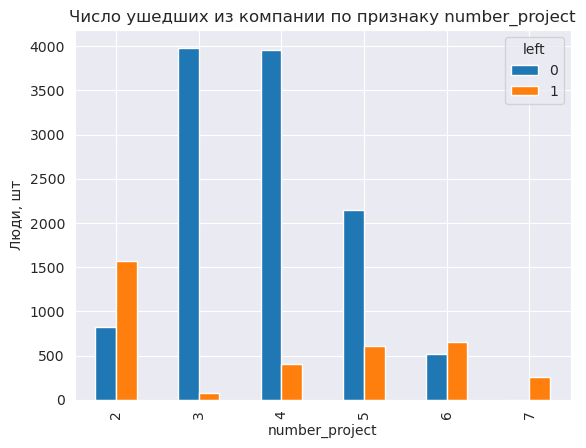

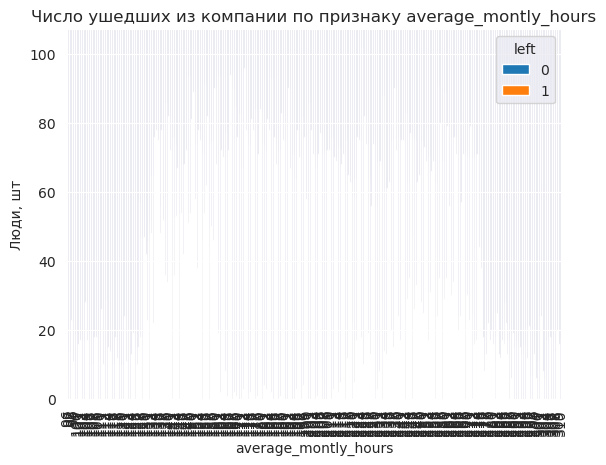

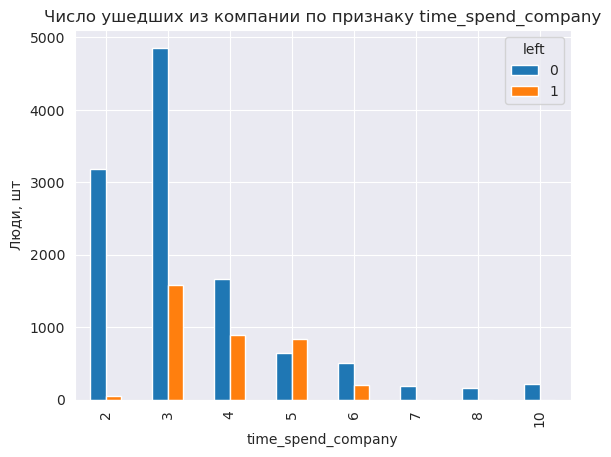

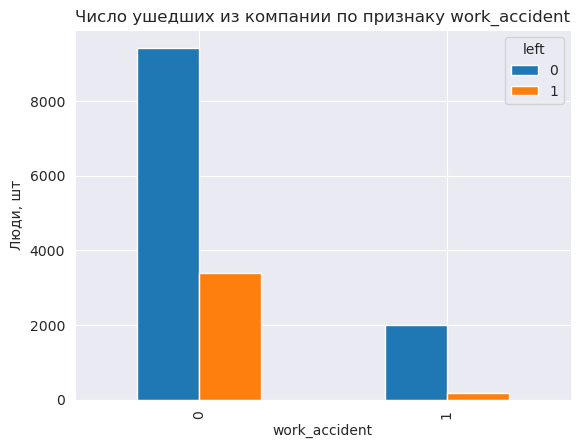

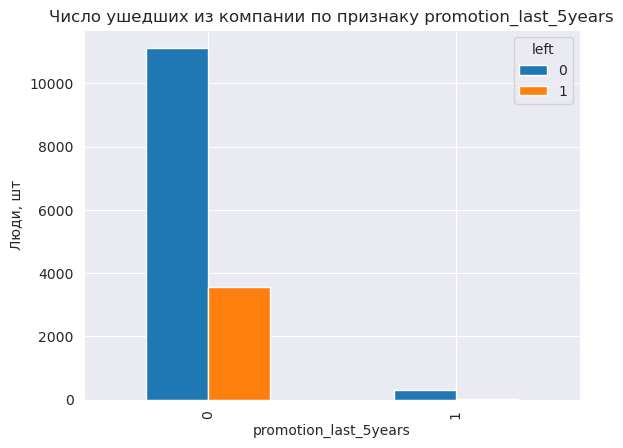

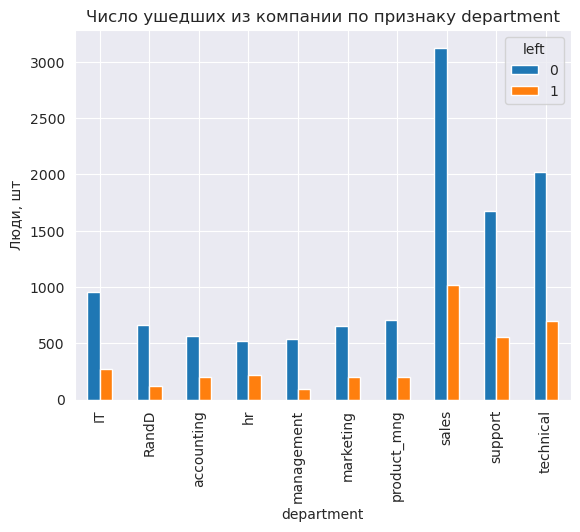

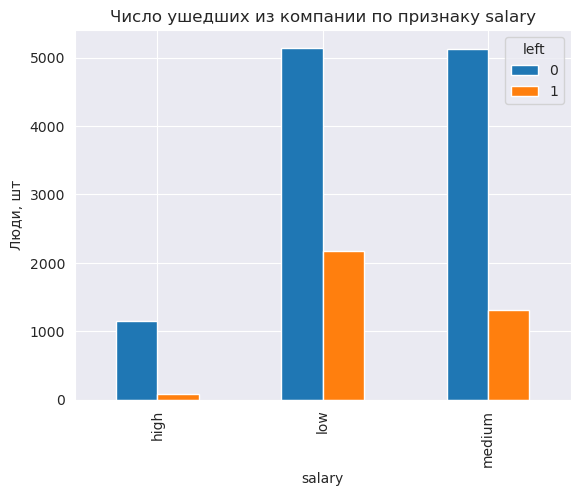

In [51]:
for column in df.columns:
    if column != 'left':
        plot_feature_vs_left(df, column)

Видно, что уходят из компании в основном люди или с очень большим числом проектов (6, 7) или с очень маленьким (2)

Так же заметно, что люди без опыта не уходят, а вот с опытом 3-5 лет начинают все активнее уходить из компании.

Как видно, чаще всего уходят из отдела продаж, поддержки и технического

In [52]:
no_acc_count = len(df[df['work_accident'] == 0])
acc_count = len(df[df['work_accident'] == 1])

df_acc = df[df['work_accident'] == 1]
df_no_acc = df[df['work_accident'] == 0]

no_acc_pct_left = len(df_no_acc[df_no_acc['left'] == 1]) / no_acc_count

acc_pct_left = len(df_acc[df_acc['left'] == 1]) / acc_count

print(f'No accident: {no_acc_pct_left}')
print(f'Accident: {acc_pct_left}')

No accident: 0.2651597817614965
Accident: 0.07791609036422315


Люди, отработавшие без происшествий уходят чаще, но не сильно, что не позволяет сделать вывод о влиянии этого признака на уход

In [53]:
df.drop(['work_accident'], axis=1, inplace=True)

Рассмотрим влияние повышения на уход из компании

In [54]:
print(f'Процент повышенных людей в компании за последние 5 лет: {(len(df[df['promotion_last_5years'] == 1]) / len(df) * 100):.2f}%')

Процент повышенных людей в компании за последние 5 лет: 2.13%


Повышенных людей всего 2%, можно этот признак убрать

In [55]:
df.drop('promotion_last_5years', axis=1, inplace=True)

Построим матрицу корреляций признаков

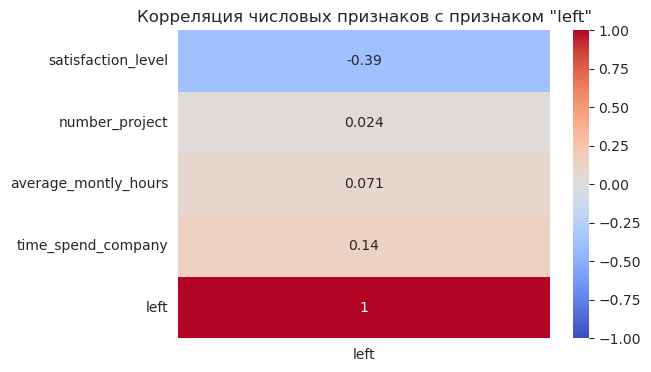

In [56]:
df_numeric = df.drop(['department', 'salary'], axis=1)

correlation = df_numeric.corr()[['left']]

plt.figure(figsize=(6, 4))
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Корреляция числовых признаков с признаком "left"')
plt.show()

Рассмотрим, сколько признаков осталось

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   satisfaction_level    14999 non-null  float64
 1   number_project        14999 non-null  int64  
 2   average_montly_hours  14999 non-null  int64  
 3   time_spend_company    14999 non-null  int64  
 4   left                  14999 non-null  int64  
 5   department            14999 non-null  object 
 6   salary                14999 non-null  object 
dtypes: float64(1), int64(4), object(2)
memory usage: 820.4+ KB


Закодируем категориальные признаки

In [60]:
df_encoded = pd.get_dummies(df, columns=['department'])

ord_encoder = OrdinalEncoder()
ord_encoder.fit(df[['salary']])
df_encoded[['salary']] = ord_encoder.fit_transform(df_encoded[['salary']])

print(df_encoded.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   satisfaction_level      14999 non-null  float64
 1   number_project          14999 non-null  int64  
 2   average_montly_hours    14999 non-null  int64  
 3   time_spend_company      14999 non-null  int64  
 4   left                    14999 non-null  int64  
 5   salary                  14999 non-null  float64
 6   department_IT           14999 non-null  bool   
 7   department_RandD        14999 non-null  bool   
 8   department_accounting   14999 non-null  bool   
 9   department_hr           14999 non-null  bool   
 10  department_management   14999 non-null  bool   
 11  department_marketing    14999 non-null  bool   
 12  department_product_mng  14999 non-null  bool   
 13  department_sales        14999 non-null  bool   
 14  department_support      14999 non-null

Далее удаляем строки, в которых указаны не уволившиеся люди и отбрасываем столбец *left*

In [61]:
df_left = df_encoded[df_encoded['left'] == 1]

X = df_encoded.drop('left', axis=1)
y = df_encoded['left']

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   satisfaction_level      14999 non-null  float64
 1   number_project          14999 non-null  int64  
 2   average_montly_hours    14999 non-null  int64  
 3   time_spend_company      14999 non-null  int64  
 4   salary                  14999 non-null  float64
 5   department_IT           14999 non-null  bool   
 6   department_RandD        14999 non-null  bool   
 7   department_accounting   14999 non-null  bool   
 8   department_hr           14999 non-null  bool   
 9   department_management   14999 non-null  bool   
 10  department_marketing    14999 non-null  bool   
 11  department_product_mng  14999 non-null  bool   
 12  department_sales        14999 non-null  bool   
 13  department_support      14999 non-null  bool   
 14  department_technical    14999 non-null

Далее проведем масштабирование данных

In [62]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

X_scaled.head()

,satisfaction_level,number_project,average_montly_hours,time_spend_company,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,-0.936495,-1.462863,-0.882040,-0.341235,-0.554955,-0.298486,-0.235321,-0.232148,-0.227647,-0.209391,-0.246322,-0.252953,1.619551,-0.417791,-0.470655
1,0.752814,0.971113,1.220423,1.713436,1.043004,-0.298486,-0.235321,-0.232148,-0.227647,-0.209391,-0.246322,-0.252953,1.619551,-0.417791,-0.470655
2,-2.022479,2.593763,1.420657,0.343655,1.043004,-0.298486,-0.235321,-0.232148,-0.227647,-0.209391,-0.246322,-0.252953,1.619551,-0.417791,-0.470655
3,0.431041,0.971113,0.439508,1.028546,-0.554955,-0.298486,-0.235321,-0.232148,-0.227647,-0.209391,-0.246322,-0.252953,1.619551,-0.417791,-0.470655
4,-0.976716,-1.462863,-0.841993,-0.341235,-0.554955,-0.298486,-0.235321,-0.232148,-0.227647,-0.209391,-0.246322,-0.252953,1.619551,-0.417791,-0.470655


Кластеризация методом Kmeans

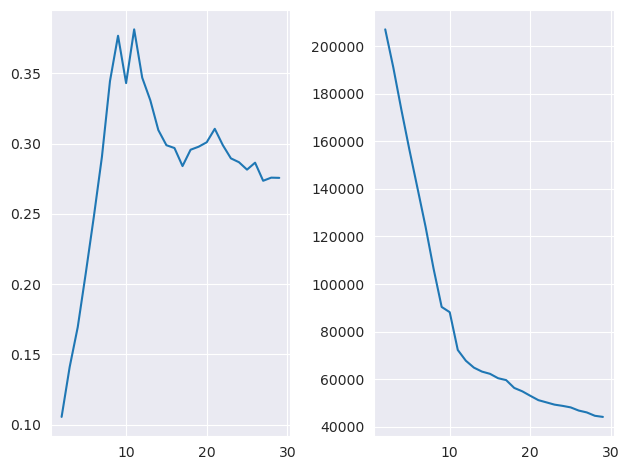

In [63]:
inertia = []
silhouettes = []

iter_max = 30

for k in range(2, iter_max):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    predicted = kmeans.predict(X_scaled)

    silhouette_avg = silhouette_score(X_scaled, predicted)

    silhouettes.append(silhouette_avg)
    inertia.append(-kmeans.score(X_scaled))

fig, axs = plt.subplots(1, 2)
axs[0].plot(range(2, iter_max), silhouettes, label='Silhouette')
axs[0].grid(True)

axs[1].plot(range(2, iter_max), inertia, label='Inertia')
axs[1].grid(True)

plt.tight_layout()
plt.show()

Наблюдается примерно 11 кластеров

In [64]:
optimal_k = 11

DBSCAN

In [65]:
from sklearn.neighbors import NearestNeighbors


def draw_dbscan_curve(X_dbscan, n=5):
    nearest = NearestNeighbors(n_neighbors=n)
    neighbors = nearest.fit(X_dbscan)
    distances, indices = neighbors.kneighbors(X_dbscan)
    distances = np.sort(distances[:, -1])

    plt.figure(figsize=(8, 5))
    plt.plot(distances)
    plt.xlabel('Объекты')
    plt.ylabel('Расстояние до 5-го ближайшего соседа')
    plt.title('Определение оптимального эпсилон для DBSCAN')
    plt.grid(True)
    plt.show()

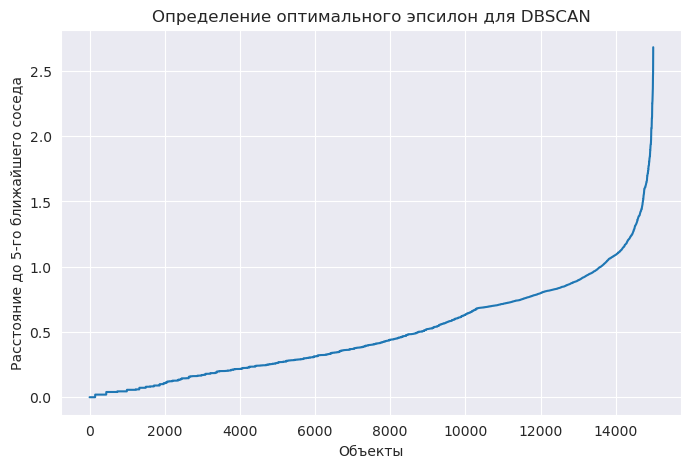

In [66]:
draw_dbscan_curve(X_scaled)

In [67]:
optimal_e = 1.2

Обучим модель К-средних и выведем кластеры на график

In [68]:
kmeans_optimal = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
clusters_k = kmeans_optimal.fit_predict(X_scaled)
unique_c_k = np.unique(clusters_k)

clusters_k.shape

(14999,)

In [69]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


In [70]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_scaled)

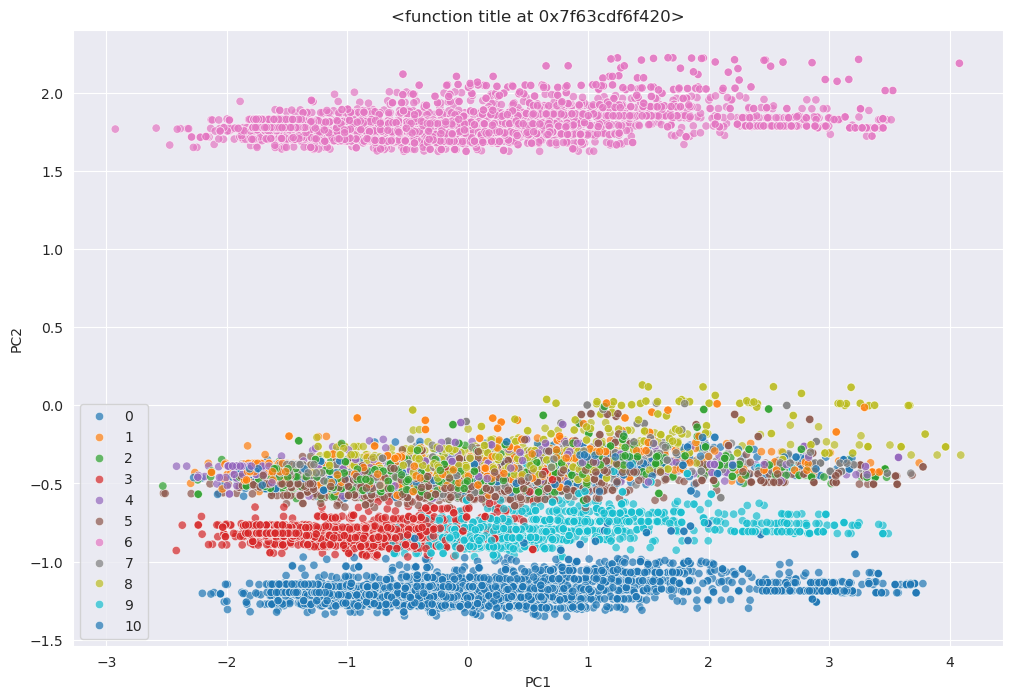

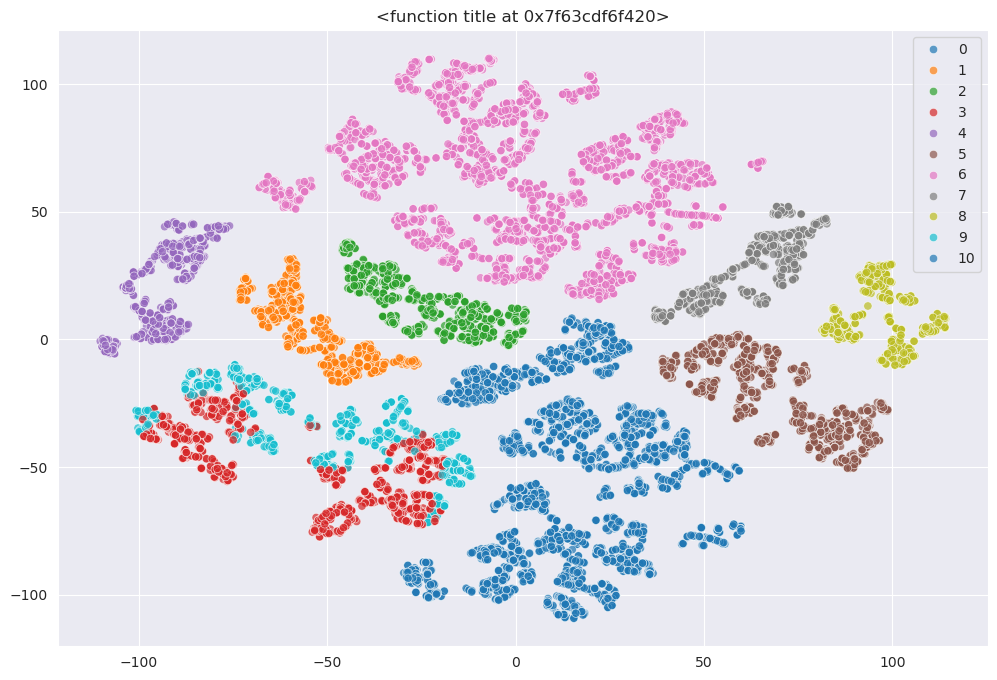

In [71]:
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["label"] = clusters_k

plt.figure(figsize=(12, 8))
sns.scatterplot(x="PC1", y="PC2", hue="label", palette="tab10", data=pca_df,alpha=0.7)
plt.title(title)
plt.legend(title='')
plt.show()

plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=clusters_k, palette="tab10", alpha=0.7)
plt.title(title)
plt.legend(title='')
plt.show()

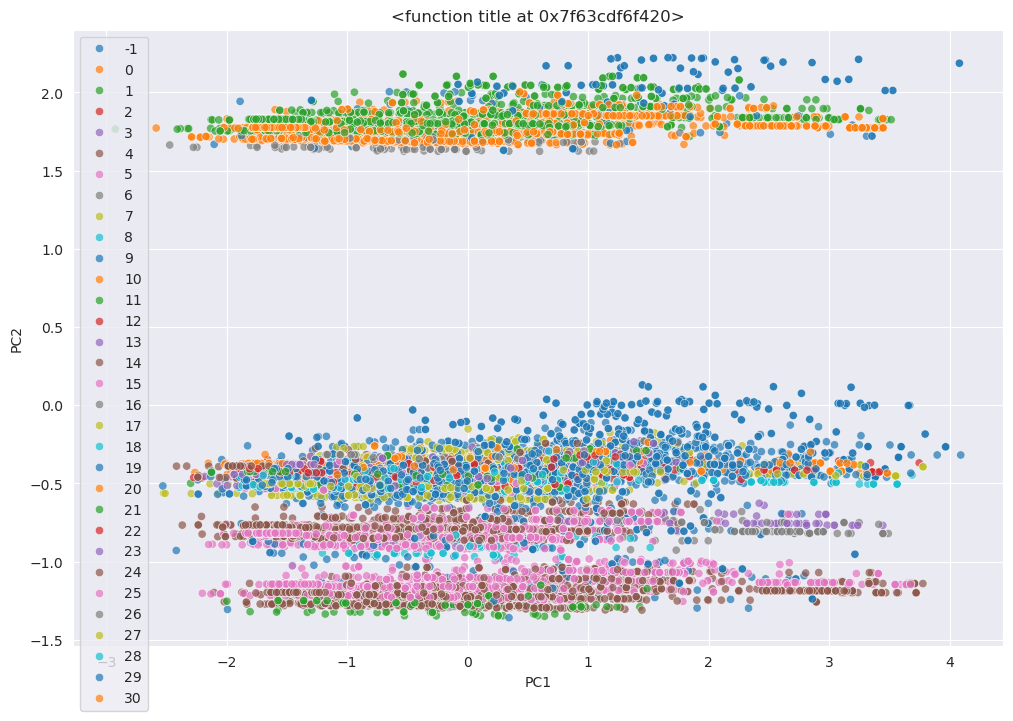

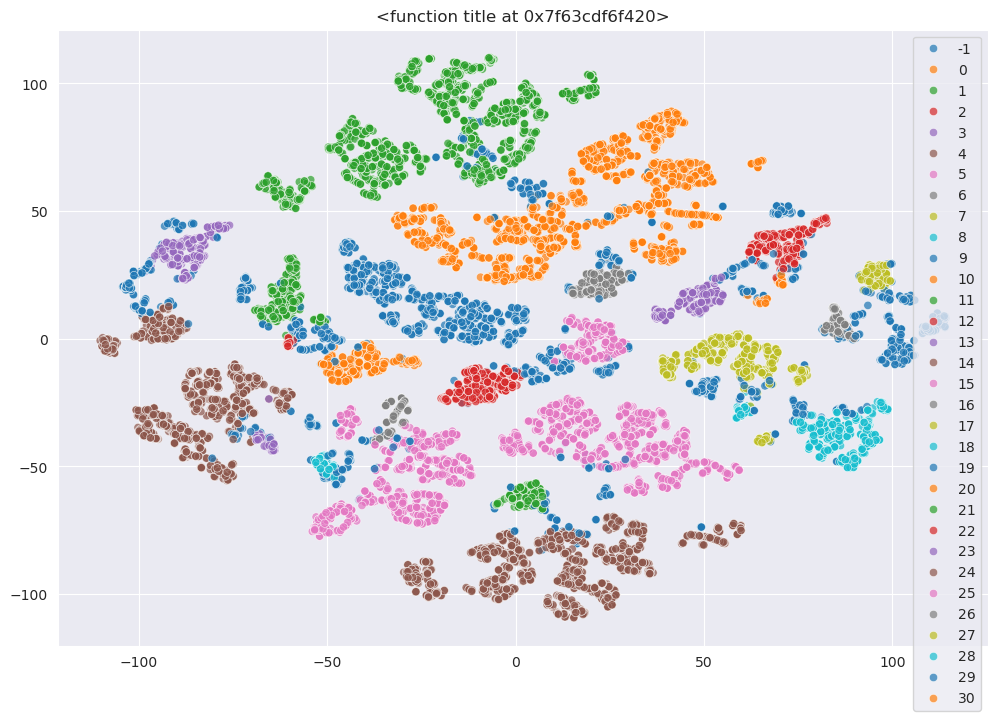

In [77]:
dbscan_optimal = DBSCAN(eps=optimal_e, min_samples=30)
clusters_db = dbscan_optimal.fit_predict(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["label"] = clusters_db

plt.figure(figsize=(12, 8))
sns.scatterplot(x="PC1", y="PC2", hue="label", palette="tab10", data=pca_df,alpha=0.7)
plt.title(title)
plt.legend(title='')
plt.show()

plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=clusters_db, palette="tab10", alpha=0.7)
plt.title(title)
plt.legend(title='')
plt.show()